In [88]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn.metrics
from sklearn.metrics import classification_report,accuracy_score,precision_recall_fscore_support

In [2]:
ETHNICITIES = ['African','Asian (East)', 'Asian (South)','Caucasian (American)','Caucasian (European)']
GENDERS = ['men','women']
METHODS = ['wav2lip','fsgan','faceswap']

# Read and Gather Predictions for Each Model

In [3]:
def get_id(path):
    return path.split('/')[-2]
    
def get_filename(path):
    return path.split('/')[-1]


def get_method(df,meta_df):
    """
        get deepfake generation method
    """
    
    methods = ['real'] * len(df)
    for index, row in df.iterrows():
        if row['label'] == 0:
            continue
            
        cond = (meta_df['source'] == row['source_id']) & (meta_df['path'] == row['filename'])
        method = meta_df[cond]['method'].values[0]
        methods[index] = method
        
    return methods

In [4]:
def filter_predictions(df,method):
    
    real_ids = df[df['label'] == 0]['source_id']
    fake_ids = df[(df['label'] == 1) & (df['method'] == method)]['source_id']
    fake_indices = []
    for real_id in real_ids:
        ids = fake_ids[fake_ids == real_id]
        if len(ids) > 0:
            fake_indices.append(ids.index[0])
    
    indices = list(real_ids.index) + fake_indices
    df =  df.iloc[indices].reset_index()
    df = df.drop(columns=['index'])
    return df
    

In [5]:
## Read prediction files for each model and join real and fake results
result_dir = './Predictions/pred_ensembles'
df_dict = {}
meta_df = pd.read_csv('./FakeAVCeleb_v1.2/meta_data.csv')
for model_name in os.listdir(result_dir):
    if '.DS_' in model_name:
        continue
    df_list = []
    for cat in os.listdir(os.path.join(result_dir,model_name)):
        if '.DS_' in cat:
            continue
        for ethnicity in os.listdir(os.path.join(result_dir,model_name,cat)):
            if '.DS_' in ethnicity:
                continue
            for gender in os.listdir(os.path.join(result_dir,model_name,cat,ethnicity)):
                if '.DS_' in gender:
                    continue
                
                path_df = os.path.join(result_dir,model_name,cat,ethnicity,gender,'results.csv')
                df = pd.read_csv(path_df)
                df_list.append(df)


    # concatenate all dfs for a model
    model_df = pd.concat(df_list).reset_index()
    model_df['path'] = model_df['path'].astype(str)
    model_df['source_id'] = model_df['path'].apply(get_id)
    model_df['filename'] = model_df['path'].apply(get_filename)
    model_df['method'] = get_method(model_df,meta_df)
    model_df = model_df.drop(columns=['index'])
    df_dict[model_name[4:]] = model_df


In [153]:
def get_label(path):
    if 'RealVideo' in path:
        return 0
    else:
        return 1

df_cvit = pd.read_csv('./preds_cross_efficient_transformer.txt')
df_cvit = df_cvit.rename(columns={'video_name':'path'})
df_cvit['path'] = df_cvit['path'].astype(str)
df_cvit['label'] = df_cvit['path'].apply(get_label)
df_cvit['source_id'] = df_cvit['path'].apply(get_id)
df_cvit['filename'] = df_cvit['path'].apply(get_filename)
df_cvit['method'] = get_method(df_cvit,meta_df)
df_cvit['gender'] = df_cvit['path'].apply(lambda x : x.split('/')[-3])
df_cvit['ethnicity'] = df_cvit['path'].apply(lambda x : x.split('/')[-4])

df_dict['CrossEffViT_DFDC_FFPP'] = df_cvit

In [6]:
df_dict.keys()

dict_keys(['EfficientNetB4_DFDC', 'EfficientNetB4_FFPP', 'EfficientNetAutoAttnB4_DFDC', 'EfficientNetB4ST_FFPP', 'Xception_DFDC', 'EfficientNetAutoAttnB4ST_FFPP', 'EfficientNetAutoAttnB4ST_DFDC', 'EfficientNetAutoAttnB4_FFPP', 'EfficientNetB4ST_DFDC', 'Xception_FFPP'])

Since we have an imbalanced dataset, we choose only one fake generated video against each real video for each generation method. We will evaluate the results on the three different generation methods separately. 

In [7]:
METHOD = 'wav2lip'
for k in df_dict.keys():
    df_dict[k] = filter_predictions(df_dict[k],method = METHOD)

### Functions

In [71]:
def get_accuracy_scores(df,thresh = 0.5):
    
    preds_proba = df['pred'].to_numpy()
    preds = np.where(preds_proba >= thresh,1,0)
    
    labels = df['label'].to_numpy()
    stats = precision_recall_fscore_support(labels,preds)
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(labels,preds_proba,pos_label=1)
    auc = sklearn.metrics.roc_auc_score(labels,preds_proba)
    stats_dict= {
        'precision_0' : stats[0][0],
        'precision_1' : stats[0][1],
        'recall_0' : stats[1][0],
        'recall_1' : stats[1][1],
        'f1_0': stats[2][0],
        'f1_1' : stats[2][1],
        'tpr': tpr,
        'fpr': fpr,
        'thresholds-roc': thresholds,
        'auc-roc':auc
    }
    
    
    return accuracy_score(labels,preds),stats_dict

def get_accuracy_scores_ethnicity(df,ethnicity,thresh=0.5):
    cond = df['ethnicity'] == ethnicity
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict

def get_accuracy_scores_gender(df,gender,thresh=0.5):
    cond = df['gender'] == gender
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


def get_accuracy_scores_ethnicity_gender(df,ethnicity,gender,thresh=0.5):
    cond = (df['gender'] == gender) & (df['ethnicity'] == ethnicity)
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


# Accuracy Analysis

### Accuracy of Each Model Overall

In [159]:
accs = []
datasets = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    acc,stats_dict = get_accuracy_scores(df)
    accs.append(acc)
    precision_0.append(stats_dict['precision_0'])
    precision_1.append(stats_dict['precision_1'])
    recall_0.append(stats_dict['recall_0'])
    recall_1.append(stats_dict['recall_1'])
    f1_0.append(stats_dict['f1_0'])
    f1_1.append(stats_dict['f1_1'])
    tpr.append(stats_dict['tpr'])
    fpr.append(stats_dict['fpr'])
    thresholds_roc.append(stats_dict['thresholds-roc'])
    auc_roc.append(stats_dict['auc-roc'])
    
    if model_name.startswith('CrossEff'):
        datasets.append('DFDC_FFPP')
        model_names.append('CrossEffViT')
    else:
        datasets.append(model_name.split('_')[-1])
        model_names.append(model_name.split('_')[0])

accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
0,EfficientNetB4,DFDC,0.612613,0.607619,0.618143,0.638,0.587174,0.622439,0.602261,"[0.0, 0.002004008016032064, 0.0160320641282565...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.006, 0.006, 0....","[1.99807537, 0.99807537, 0.99170566, 0.9904442...",0.665800
6,EfficientNetAutoAttnB4ST,DFDC,0.633634,0.615917,0.657957,0.712,0.555110,0.660482,0.602174,"[0.0, 0.002004008016032064, 0.0020040080160320...","[0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0.008, ...","[1.9860843, 0.9860843, 0.9757229, 0.9456628, 0...",0.678990
8,EfficientNetB4ST,DFDC,0.627628,0.604235,0.664935,0.742,0.513026,0.666068,0.579186,"[0.0, 0.002004008016032064, 0.0100200400801603...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9778983, 0.9778983, 0.9680903, 0.9651468, 0...",0.688810
4,Xception,DFDC,0.616617,0.576471,0.747863,0.882,0.350701,0.697233,0.477490,"[0.0, 0.002004008016032064, 0.0140280561122244...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.008, 0.008, 0....","[1.9958331, 0.9958331, 0.98858684, 0.98833966,...",0.711182
2,EfficientNetAutoAttnB4,DFDC,0.663664,0.649635,0.680710,0.712,0.615230,0.679389,0.646316,"[0.0, 0.002004008016032064, 0.0380761523046092...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.006, 0.006, 0....","[1.9966401, 0.9966401, 0.98699933, 0.9869153, ...",0.729307
9,Xception,FFPP,0.658659,0.603651,0.840517,0.926,0.390782,0.730860,0.533516,"[0.0, 0.002004008016032064, 0.0180360721442885...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0....","[1.99123305, 0.99123305, 0.9543904, 0.9486518,...",0.788084
3,EfficientNetB4ST,FFPP,0.685686,0.628099,0.838828,0.912,0.458918,0.743883,0.593264,"[0.0, 0.002004008016032064, 0.1082164328657314...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9677319, 0.9677319, 0.870079, 0.8694447, 0....",0.813904
7,EfficientNetAutoAttnB4,FFPP,0.659660,0.603093,0.856502,0.936,0.382766,0.733542,0.529086,"[0.0, 0.002004008016032064, 0.0120240480961923...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9895971399999999, 0.98959714, 0.9638687, 0....",0.837403
1,EfficientNetB4,FFPP,0.682683,0.623816,0.850000,0.922,0.442886,0.744149,0.582345,"[0.0, 0.002004008016032064, 0.0501002004008016...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9866789, 0.9866789, 0.94527984, 0.9435221, ...",0.839952
5,EfficientNetAutoAttnB4ST,FFPP,0.636637,0.584049,0.869565,0.952,0.320641,0.723954,0.468521,"[0.0, 0.002004008016032064, 0.1102204408817635...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9639123, 0.9639123, 0.8157977, 0.81034005, ...",0.845034


In [172]:
cols_to_use = ['model',	'training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
accuracy_df = accuracy_df.round(decimals=2)
accuracy_df[cols_to_use].to_csv('./tables/overall_wav2lip.csv',index=False)

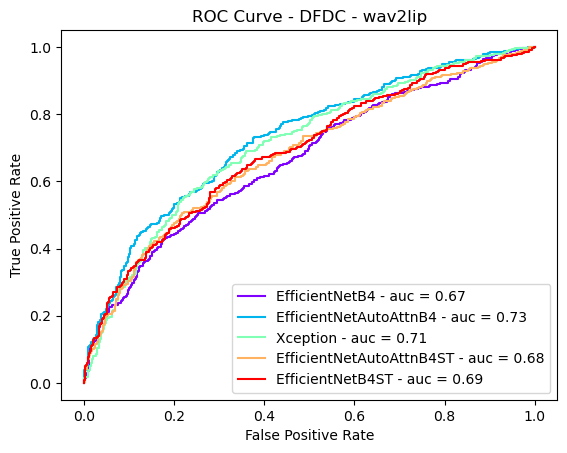

In [100]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC - wav2lip")
plt.legend(loc="lower right")
plt.show()

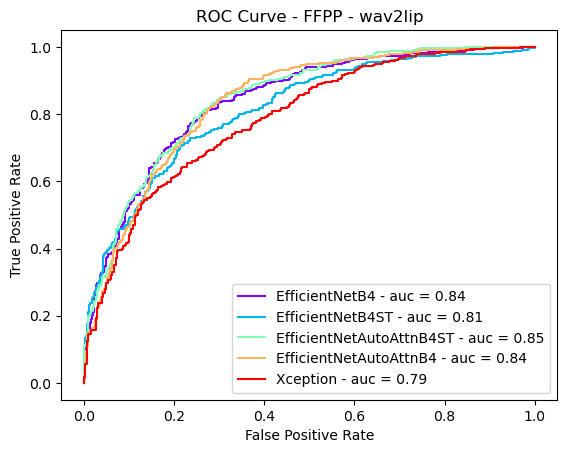

In [101]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFPP - wav2lip")
plt.legend(loc="lower right")
plt.show()

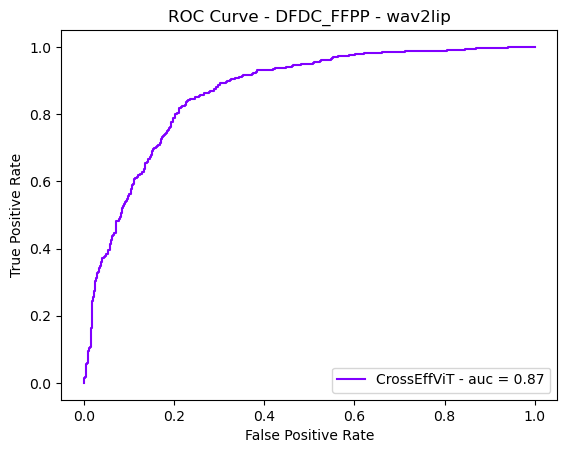

In [160]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC_FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC_FFPP - wav2lip")
plt.legend(loc="lower right")
plt.show()

## Ethnic Group

In [178]:
accs = []
datasets = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []
for model_name,df in df_dict.items():
    
    for eth in ETHNICITIES:
        acc,stats_dict = get_accuracy_scores_ethnicity(df,eth)
        ethnics.append(eth)
        accs.append(acc)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


ethnic_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'ethnicity': ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

ethnic_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
0,EfficientNetB4,DFDC,African,0.585000,0.579439,0.591398,0.62,0.550000,0.599034,0.569948,"[0.0, 0.01, 0.01, 0.09, 0.09, 0.1, 0.1, 0.11, ...","[0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03,...","[1.9962889000000001, 0.9962889, 0.99044424, 0....",0.625900
2,EfficientNetB4,DFDC,Asian (South),0.595000,0.590476,0.600000,0.62,0.570000,0.604878,0.584615,"[0.0, 0.01, 0.03, 0.03, 0.12, 0.12, 0.17, 0.17...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.05, 0.05, 0.06, ...","[1.99807537, 0.99807537, 0.9966149, 0.98632634...",0.655600
4,EfficientNetB4,DFDC,Caucasian (European),0.590000,0.573770,0.615385,0.70,0.480000,0.630631,0.539326,"[0.0, 0.01, 0.02, 0.02, 0.04, 0.04, 0.1, 0.1, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9978382, 0.9978382, 0.99170566, 0.99132043,...",0.659500
40,EfficientNetB4ST,DFDC,African,0.605000,0.584000,0.640000,0.73,0.480000,0.648889,0.548571,"[0.0, 0.01, 0.02, 0.02, 0.08, 0.08, 0.12, 0.12...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9688816999999998, 0.9688817, 0.9680903, 0.9...",0.664000
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.605000,0.584000,0.640000,0.73,0.480000,0.648889,0.548571,"[0.0, 0.01, 0.01, 0.06, 0.06, 0.09, 0.09, 0.14...","[0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03,...","[1.9860843, 0.9860843, 0.9757229, 0.9538457, 0...",0.665600
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.635000,0.615385,0.662651,0.72,0.550000,0.663594,0.601093,"[0.0, 0.01, 0.03, 0.03, 0.06, 0.06, 0.1, 0.1, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9630865499999999, 0.96308655, 0.9509163, 0....",0.668300
3,EfficientNetB4,DFDC,Caucasian (American),0.625000,0.621359,0.628866,0.64,0.610000,0.630542,0.619289,"[0.0, 0.01, 0.11, 0.11, 0.13, 0.13, 0.2, 0.2, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99291456, 0.99291456, 0.9734717, 0.97293764...",0.675000
30,EfficientNetAutoAttnB4ST,DFDC,African,0.650000,0.622951,0.692308,0.76,0.540000,0.684685,0.606742,"[0.0, 0.01, 0.05, 0.05, 0.06, 0.06, 0.15, 0.15...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.94736516, 0.94736516, 0.9397794, 0.92325276...",0.675300
42,EfficientNetB4ST,DFDC,Asian (South),0.620000,0.601695,0.646341,0.71,0.530000,0.651376,0.582418,"[0.0, 0.01, 0.07, 0.07, 0.08, 0.08, 0.14, 0.14...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9778983, 0.9778983, 0.9395077, 0.9341821, 0...",0.681200
44,EfficientNetB4ST,DFDC,Caucasian (European),0.590000,0.567164,0.636364,0.76,0.420000,0.649573,0.506024,"[0.0, 0.01, 0.04, 0.04, 0.05, 0.05, 0.08, 0.08...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9761839, 0.9761839, 0.9459049, 0.94048065, ...",0.684300


In [179]:
cols_to_use = ['model',	'ethnicity','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
ethnic_accuracy_df = ethnic_accuracy_df.round(decimals=2)
ethnic_accuracy_df[cols_to_use].to_csv('./tables/ethnicities/wav2lip.csv',index=False)

In [151]:
ethnic_accuracy_df.sort_values(by=['f1_1'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
25,EfficientNetAutoAttnB4ST,FFPP,African,0.590000,0.550562,0.909091,0.98,0.200000,0.705036,0.327869,"[0.0, 0.01, 0.18, 0.18, 0.2, 0.2, 0.37, 0.37, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9207313, 0.9207313, 0.5290468, 0.52544314, ...",0.841800
24,Xception,DFDC,Caucasian (European),0.590000,0.555556,0.736842,0.90,0.280000,0.687023,0.405797,"[0.0, 0.01, 0.03, 0.03, 0.05, 0.05, 0.08, 0.08...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9903043, 0.9903043, 0.98764765, 0.9824013, ...",0.701700
45,Xception,FFPP,African,0.610000,0.566265,0.823529,0.94,0.280000,0.706767,0.417910,"[0.0, 0.01, 0.06, 0.06, 0.08, 0.08, 0.19, 0.19...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9612062, 0.9612062, 0.8134751, 0.7977816, 0...",0.745400
20,Xception,DFDC,African,0.595000,0.559748,0.731707,0.89,0.300000,0.687259,0.425532,"[0.0, 0.01, 0.02, 0.02, 0.04, 0.04, 0.07, 0.07...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99463034, 0.99463034, 0.99173975, 0.9826693...",0.709200
35,EfficientNetAutoAttnB4,FFPP,African,0.635000,0.579882,0.935484,0.98,0.290000,0.728625,0.442748,"[0.0, 0.01, 0.04, 0.04, 0.05, 0.05, 0.31, 0.31...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.05, ...","[1.9344345, 0.9344345, 0.8582388, 0.82885814, ...",0.821300
28,EfficientNetAutoAttnB4ST,FFPP,Caucasian (American),0.640000,0.585366,0.888889,0.96,0.320000,0.727273,0.470588,"[0.0, 0.01, 0.19, 0.19, 0.24, 0.24, 0.26, 0.26...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9512535, 0.9512535, 0.7036403, 0.6633358, 0...",0.871100
26,EfficientNetAutoAttnB4ST,FFPP,Asian (East),0.623116,0.581699,0.760870,0.89,0.353535,0.703557,0.482759,"[0.0, 0.010101010101010102, 0.1515151515151515...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0.03, 0.04, ...","[1.9639123, 0.9639123, 0.81801414, 0.7801356, ...",0.794444
27,EfficientNetAutoAttnB4ST,FFPP,Asian (South),0.655000,0.593939,0.942857,0.98,0.330000,0.739623,0.488889,"[0.0, 0.01, 0.28, 0.28, 0.3, 0.3, 0.35, 0.35, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.91923445, 0.91923445, 0.57602406, 0.5354454...",0.846800
5,EfficientNetB4,FFPP,African,0.645000,0.590062,0.871795,0.95,0.340000,0.727969,0.489209,"[0.0, 0.01, 0.08, 0.08, 0.17, 0.17, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9292970999999999, 0.9292971, 0.8063198, 0.8...",0.813300
15,EfficientNetB4ST,FFPP,African,0.650000,0.592593,0.894737,0.96,0.340000,0.732824,0.492754,"[0.0, 0.01, 0.1, 0.1, 0.19, 0.19, 0.29, 0.29, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9292970999999999, 0.9292971, 0.7622107, 0.7...",0.766400


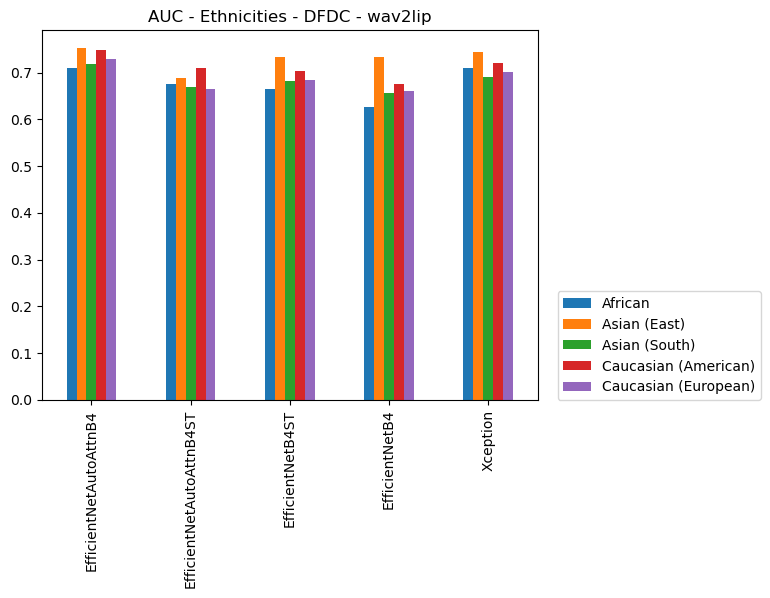

In [142]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - DFDC - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [128]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)

for df_ in temp_dfs:
    print(df_)

                     model     ethnicity  accuracy   auc-roc
10  EfficientNetAutoAttnB4       African  0.630000  0.708700
11  EfficientNetAutoAttnB4  Asian (East)  0.673367  0.752727
                       model             ethnicity  accuracy  auc-roc
34  EfficientNetAutoAttnB4ST  Caucasian (European)     0.605   0.6656
33  EfficientNetAutoAttnB4ST  Caucasian (American)     0.655   0.7096
               model     ethnicity  accuracy   auc-roc
40  EfficientNetB4ST       African  0.605000  0.664000
41  EfficientNetB4ST  Asian (East)  0.673367  0.733333
            model     ethnicity  accuracy   auc-roc
0  EfficientNetB4       African  0.585000  0.625900
1  EfficientNetB4  Asian (East)  0.668342  0.732525
       model      ethnicity  accuracy   auc-roc
22  Xception  Asian (South)  0.620000  0.689900
21  Xception   Asian (East)  0.643216  0.744646


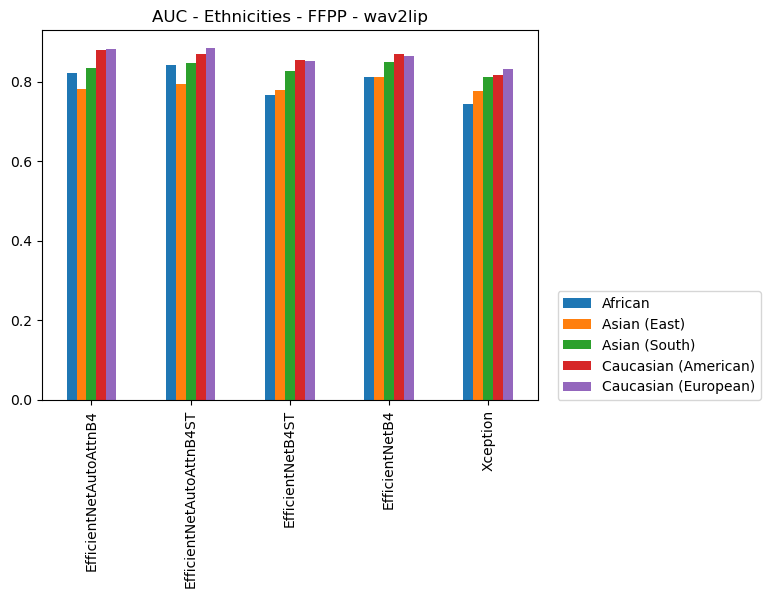

In [143]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - FFPP - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [129]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

                     model             ethnicity  accuracy   auc-roc
36  EfficientNetAutoAttnB4          Asian (East)  0.673367  0.782222
39  EfficientNetAutoAttnB4  Caucasian (European)  0.700000  0.882500
                       model             ethnicity  accuracy   auc-roc
26  EfficientNetAutoAttnB4ST          Asian (East)  0.623116  0.794444
29  EfficientNetAutoAttnB4ST  Caucasian (European)  0.675000  0.885300
               model             ethnicity  accuracy  auc-roc
15  EfficientNetB4ST               African     0.650   0.7664
18  EfficientNetB4ST  Caucasian (American)     0.675   0.8559
            model             ethnicity  accuracy   auc-roc
6  EfficientNetB4          Asian (East)  0.678392  0.811717
8  EfficientNetB4  Caucasian (American)  0.655000  0.869600
       model             ethnicity  accuracy  auc-roc
45  Xception               African      0.61   0.7454
49  Xception  Caucasian (European)      0.66   0.8328


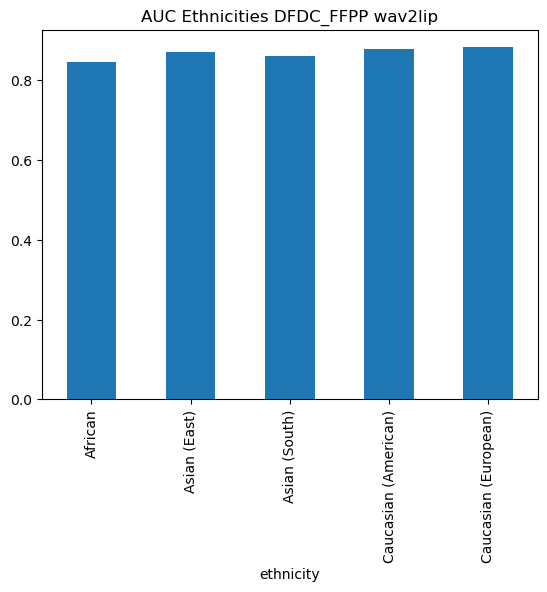

In [162]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='ethnicity',y='auc-roc',title='AUC Ethnicities DFDC_FFPP wav2lip',legend=False)
plt.show()

#### Groups with low to high accuracy ( models trained on DFDC )

In [76]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
0,EfficientNetB4,DFDC,African,0.585000,0.579439,0.591398,0.62,0.550000,0.599034,0.569948,"[0.0, 0.01, 0.01, 0.09, 0.09, 0.1, 0.1, 0.11, ...","[0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03,...","[1.9962889000000001, 0.9962889, 0.99044424, 0....",0.625900
2,EfficientNetB4,DFDC,Asian (South),0.595000,0.590476,0.600000,0.62,0.570000,0.604878,0.584615,"[0.0, 0.01, 0.03, 0.03, 0.12, 0.12, 0.17, 0.17...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.05, 0.05, 0.06, ...","[1.99807537, 0.99807537, 0.9966149, 0.98632634...",0.655600
4,EfficientNetB4,DFDC,Caucasian (European),0.590000,0.573770,0.615385,0.70,0.480000,0.630631,0.539326,"[0.0, 0.01, 0.02, 0.02, 0.04, 0.04, 0.1, 0.1, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9978382, 0.9978382, 0.99170566, 0.99132043,...",0.659500
40,EfficientNetB4ST,DFDC,African,0.605000,0.584000,0.640000,0.73,0.480000,0.648889,0.548571,"[0.0, 0.01, 0.02, 0.02, 0.08, 0.08, 0.12, 0.12...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9688816999999998, 0.9688817, 0.9680903, 0.9...",0.664000
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.605000,0.584000,0.640000,0.73,0.480000,0.648889,0.548571,"[0.0, 0.01, 0.01, 0.06, 0.06, 0.09, 0.09, 0.14...","[0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03,...","[1.9860843, 0.9860843, 0.9757229, 0.9538457, 0...",0.665600
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.635000,0.615385,0.662651,0.72,0.550000,0.663594,0.601093,"[0.0, 0.01, 0.03, 0.03, 0.06, 0.06, 0.1, 0.1, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9630865499999999, 0.96308655, 0.9509163, 0....",0.668300
3,EfficientNetB4,DFDC,Caucasian (American),0.625000,0.621359,0.628866,0.64,0.610000,0.630542,0.619289,"[0.0, 0.01, 0.11, 0.11, 0.13, 0.13, 0.2, 0.2, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99291456, 0.99291456, 0.9734717, 0.97293764...",0.675000
30,EfficientNetAutoAttnB4ST,DFDC,African,0.650000,0.622951,0.692308,0.76,0.540000,0.684685,0.606742,"[0.0, 0.01, 0.05, 0.05, 0.06, 0.06, 0.15, 0.15...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.94736516, 0.94736516, 0.9397794, 0.92325276...",0.675300
42,EfficientNetB4ST,DFDC,Asian (South),0.620000,0.601695,0.646341,0.71,0.530000,0.651376,0.582418,"[0.0, 0.01, 0.07, 0.07, 0.08, 0.08, 0.14, 0.14...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9778983, 0.9778983, 0.9395077, 0.9341821, 0...",0.681200
44,EfficientNetB4ST,DFDC,Caucasian (European),0.590000,0.567164,0.636364,0.76,0.420000,0.649573,0.506024,"[0.0, 0.01, 0.04, 0.04, 0.05, 0.05, 0.08, 0.08...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9761839, 0.9761839, 0.9459049, 0.94048065, ...",0.684300


#### Groups with low to high accuracy ( models trained on FFPP)

In [77]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
45,Xception,FFPP,African,0.610000,0.566265,0.823529,0.94,0.280000,0.706767,0.417910,"[0.0, 0.01, 0.06, 0.06, 0.08, 0.08, 0.19, 0.19...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9612062, 0.9612062, 0.8134751, 0.7977816, 0...",0.745400
15,EfficientNetB4ST,FFPP,African,0.650000,0.592593,0.894737,0.96,0.340000,0.732824,0.492754,"[0.0, 0.01, 0.1, 0.1, 0.19, 0.19, 0.29, 0.29, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9292970999999999, 0.9292971, 0.7622107, 0.7...",0.766400
46,Xception,FFPP,Asian (East),0.633166,0.589404,0.770833,0.89,0.373737,0.709163,0.503401,"[0.0, 0.010101010101010102, 0.0404040404040404...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.05, 0.05, 0.06, ...","[1.97703665, 0.97703665, 0.9336654, 0.8963505,...",0.777172
16,EfficientNetB4ST,FFPP,Asian (East),0.688442,0.646154,0.768116,0.84,0.535354,0.730435,0.630952,"[0.0, 0.010101010101010102, 0.1616161616161616...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9677319, 0.9677319, 0.8730582, 0.8694447, 0...",0.779899
36,EfficientNetAutoAttnB4,FFPP,Asian (East),0.673367,0.622378,0.803571,0.89,0.454545,0.732510,0.580645,"[0.0, 0.010101010101010102, 0.0303030303030303...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.05, ...","[1.9710164, 0.9710164, 0.91152436, 0.8977813, ...",0.782222
26,EfficientNetAutoAttnB4ST,FFPP,Asian (East),0.623116,0.581699,0.760870,0.89,0.353535,0.703557,0.482759,"[0.0, 0.010101010101010102, 0.1515151515151515...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0.03, 0.04, ...","[1.9639123, 0.9639123, 0.81801414, 0.7801356, ...",0.794444
6,EfficientNetB4,FFPP,Asian (East),0.678392,0.625000,0.818182,0.90,0.454545,0.737705,0.584416,"[0.0, 0.010101010101010102, 0.0404040404040404...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9865637999999999, 0.9865638, 0.9731887, 0.9...",0.811717
47,Xception,FFPP,Asian (South),0.735000,0.674074,0.861538,0.91,0.560000,0.774468,0.678788,"[0.0, 0.01, 0.02, 0.02, 0.23, 0.23, 0.34, 0.34...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.07, ...","[1.99123305, 0.99123305, 0.97030354, 0.9486518...",0.811800
5,EfficientNetB4,FFPP,African,0.645000,0.590062,0.871795,0.95,0.340000,0.727969,0.489209,"[0.0, 0.01, 0.08, 0.08, 0.17, 0.17, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9292970999999999, 0.9292971, 0.8063198, 0.8...",0.813300
48,Xception,FFPP,Caucasian (American),0.655000,0.596273,0.897436,0.96,0.350000,0.735632,0.503597,"[0.0, 0.01, 0.17, 0.17, 0.2, 0.2, 0.26, 0.26, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9666483399999999, 0.96664834, 0.80128944, 0...",0.817600


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP)

In [164]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
50,CrossEffViT,DFDC_FFPP,African,0.725000,0.674419,0.816901,0.87,0.580000,0.759825,0.678363,"[0.0, 0.01, 0.03, 0.03, 0.11, 0.11, 0.31, 0.31...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9996527400000002, 0.99965274, 0.99897903, 0...",0.845100
52,CrossEffViT,DFDC_FFPP,Asian (South),0.735000,0.674074,0.861538,0.91,0.560000,0.774468,0.678788,"[0.0, 0.01, 0.07, 0.07, 0.21, 0.21, 0.34, 0.34...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9960909500000001, 0.99609095, 0.9546162, 0....",0.860500
51,CrossEffViT,DFDC_FFPP,Asian (East),0.753769,0.707317,0.828947,0.87,0.636364,0.780269,0.720000,"[0.0, 0.010101010101010102, 0.0101010101010101...","[0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03,...","[1.9999331, 0.9999331, 0.99694365, 0.97033423,...",0.869596
53,CrossEffViT,DFDC_FFPP,Caucasian (American),0.730000,0.661972,0.896552,0.94,0.520000,0.776860,0.658228,"[0.0, 0.01, 0.06, 0.06, 0.12, 0.12, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99857473, 0.99857473, 0.9743938, 0.9606824,...",0.878800
54,CrossEffViT,DFDC_FFPP,Caucasian (European),0.695000,0.634483,0.854545,0.92,0.470000,0.751020,0.606452,"[0.0, 0.01, 0.07, 0.07, 0.24, 0.24, 0.26, 0.26...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0.03, 0.04, ...","[1.9979697, 0.9979697, 0.91391313, 0.91019475,...",0.881500


## Gender Group

In [176]:
accs = []
datasets = []
genders = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        acc,stats_dict = get_accuracy_scores_gender(df,gender)
        accs.append(acc)
        genders.append(gender)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


gender_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
1,EfficientNetB4,DFDC,women,0.622000,0.598071,0.661376,0.744,0.500000,0.663102,0.569476,"[0.0, 0.004, 0.02, 0.02, 0.028, 0.028, 0.04, 0...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99807537, 0.99807537, 0.99170566, 0.9913204...",0.659280
13,EfficientNetAutoAttnB4ST,DFDC,women,0.632000,0.592179,0.732394,0.848,0.416000,0.697368,0.530612,"[0.0, 0.004, 0.044, 0.044, 0.056, 0.056, 0.072...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9628109, 0.9628109, 0.9232181, 0.91895264, ...",0.664272
17,EfficientNetB4ST,DFDC,women,0.608000,0.574586,0.695652,0.832,0.384000,0.679739,0.494845,"[0.0, 0.004, 0.028, 0.028, 0.036, 0.036, 0.056...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9778983, 0.9778983, 0.9459049, 0.94048065, ...",0.678048
0,EfficientNetB4,DFDC,men,0.603206,0.621495,0.589474,0.532,0.674699,0.573276,0.629213,"[0.0, 0.004016064257028112, 0.0120481927710843...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9966149, 0.9966149, 0.99291456, 0.99044424,...",0.683614
9,Xception,DFDC,women,0.594000,0.558603,0.737374,0.896,0.292000,0.688172,0.418338,"[0.0, 0.004, 0.012, 0.012, 0.016, 0.016, 0.06,...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9939298600000002, 0.99392986, 0.98858684, 0...",0.694128
5,EfficientNetAutoAttnB4,DFDC,women,0.652000,0.629252,0.684466,0.740,0.564000,0.680147,0.618421,"[0.0, 0.004, 0.052, 0.052, 0.064, 0.064, 0.072...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9966401, 0.9966401, 0.98699933, 0.9869153, ...",0.707728
12,EfficientNetAutoAttnB4ST,DFDC,men,0.635271,0.654545,0.620072,0.576,0.694779,0.612766,0.655303,"[0.0, 0.004016064257028112, 0.0040160642570281...","[0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0.016, ...","[1.9860843, 0.9860843, 0.9757229, 0.9456628, 0...",0.707936
16,EfficientNetB4ST,DFDC,men,0.647295,0.646825,0.647773,0.652,0.642570,0.649402,0.645161,"[0.0, 0.004016064257028112, 0.0160642570281124...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9761839, 0.9761839, 0.9680903, 0.9651468, 0...",0.712289
8,Xception,DFDC,men,0.639279,0.596154,0.755556,0.868,0.409639,0.706840,0.531250,"[0.0, 0.004016064257028112, 0.0160642570281124...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9958331, 0.9958331, 0.9903043, 0.98833966, ...",0.727920
4,EfficientNetAutoAttnB4,DFDC,men,0.675351,0.673228,0.677551,0.684,0.666667,0.678571,0.672065,"[0.0, 0.004016064257028112, 0.0240963855421686...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99398935, 0.99398935, 0.9890603, 0.9869398,...",0.752241


In [177]:
cols_to_use = ['model','gender','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_accuracy_df = gender_accuracy_df.round(decimals=2)
gender_accuracy_df[cols_to_use].to_csv('./tables/gender/wav2lip.csv',index=False)

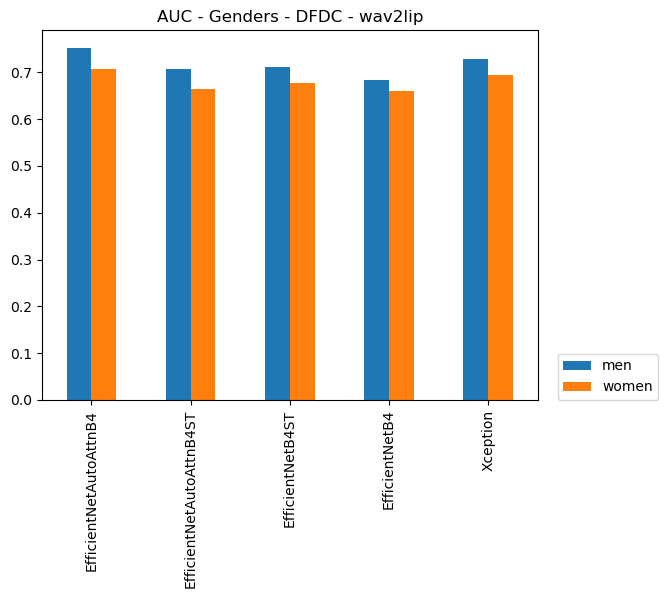

In [147]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - DFDC - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [126]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

                    model gender  accuracy   auc-roc
5  EfficientNetAutoAttnB4  women  0.652000  0.707728
4  EfficientNetAutoAttnB4    men  0.675351  0.752241
                       model gender  accuracy   auc-roc
13  EfficientNetAutoAttnB4ST  women  0.632000  0.664272
12  EfficientNetAutoAttnB4ST    men  0.635271  0.707936
               model gender  accuracy   auc-roc
17  EfficientNetB4ST  women  0.608000  0.678048
16  EfficientNetB4ST    men  0.647295  0.712289
            model gender  accuracy   auc-roc
1  EfficientNetB4  women  0.622000  0.659280
0  EfficientNetB4    men  0.603206  0.683614
      model gender  accuracy   auc-roc
9  Xception  women  0.594000  0.694128
8  Xception    men  0.639279  0.727920


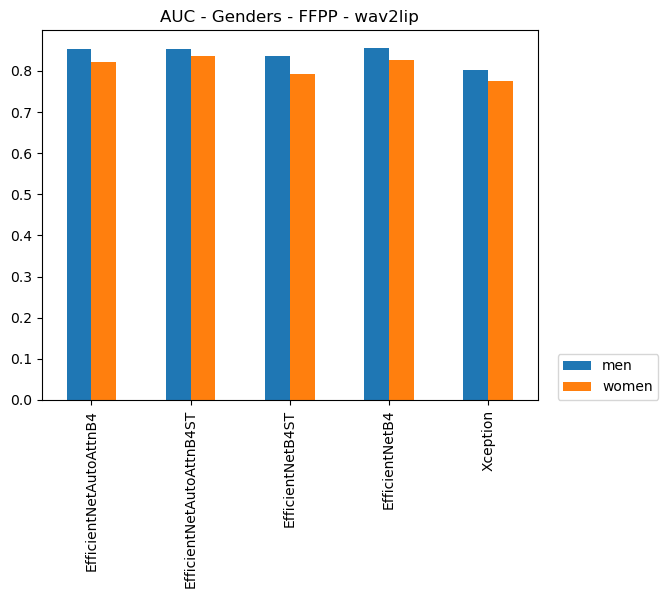

In [148]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - FFPP - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [127]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

                     model gender  accuracy   auc-roc
15  EfficientNetAutoAttnB4  women  0.672000  0.822784
14  EfficientNetAutoAttnB4    men  0.647295  0.852867
                       model gender  accuracy   auc-roc
11  EfficientNetAutoAttnB4ST  women  0.642000  0.835824
10  EfficientNetAutoAttnB4ST    men  0.631263  0.854361
              model gender  accuracy   auc-roc
7  EfficientNetB4ST  women  0.666000  0.793248
6  EfficientNetB4ST    men  0.705411  0.837189
            model gender  accuracy   auc-roc
3  EfficientNetB4  women  0.670000  0.825504
2  EfficientNetB4    men  0.695391  0.855920
       model gender  accuracy   auc-roc
19  Xception  women  0.664000  0.775440
18  Xception    men  0.653307  0.801847


<AxesSubplot:title={'center':'AUC Gender DFDC_FFPP wav2lip'}, xlabel='gender'>

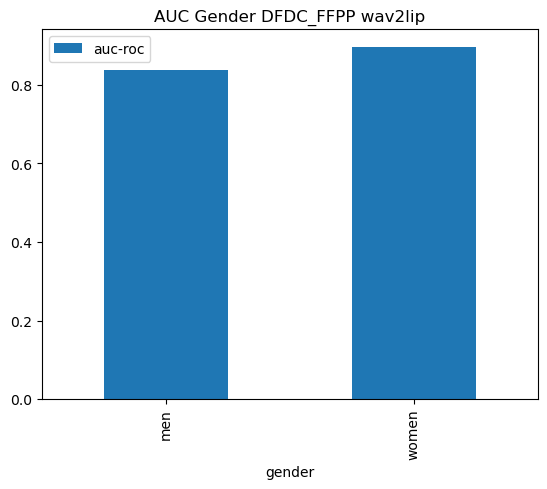

In [167]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='gender',y='auc-roc',title='AUC Gender DFDC_FFPP wav2lip')

#### Groups with low to high accuracy ( models trained on DFDC )

In [80]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
1,EfficientNetB4,DFDC,women,0.622000,0.598071,0.661376,0.744,0.500000,0.663102,0.569476,"[0.0, 0.004, 0.02, 0.02, 0.028, 0.028, 0.04, 0...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99807537, 0.99807537, 0.99170566, 0.9913204...",0.659280
13,EfficientNetAutoAttnB4ST,DFDC,women,0.632000,0.592179,0.732394,0.848,0.416000,0.697368,0.530612,"[0.0, 0.004, 0.044, 0.044, 0.056, 0.056, 0.072...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9628109, 0.9628109, 0.9232181, 0.91895264, ...",0.664272
17,EfficientNetB4ST,DFDC,women,0.608000,0.574586,0.695652,0.832,0.384000,0.679739,0.494845,"[0.0, 0.004, 0.028, 0.028, 0.036, 0.036, 0.056...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9778983, 0.9778983, 0.9459049, 0.94048065, ...",0.678048
0,EfficientNetB4,DFDC,men,0.603206,0.621495,0.589474,0.532,0.674699,0.573276,0.629213,"[0.0, 0.004016064257028112, 0.0120481927710843...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9966149, 0.9966149, 0.99291456, 0.99044424,...",0.683614
9,Xception,DFDC,women,0.594000,0.558603,0.737374,0.896,0.292000,0.688172,0.418338,"[0.0, 0.004, 0.012, 0.012, 0.016, 0.016, 0.06,...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9939298600000002, 0.99392986, 0.98858684, 0...",0.694128
5,EfficientNetAutoAttnB4,DFDC,women,0.652000,0.629252,0.684466,0.740,0.564000,0.680147,0.618421,"[0.0, 0.004, 0.052, 0.052, 0.064, 0.064, 0.072...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9966401, 0.9966401, 0.98699933, 0.9869153, ...",0.707728
12,EfficientNetAutoAttnB4ST,DFDC,men,0.635271,0.654545,0.620072,0.576,0.694779,0.612766,0.655303,"[0.0, 0.004016064257028112, 0.0040160642570281...","[0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0.016, ...","[1.9860843, 0.9860843, 0.9757229, 0.9456628, 0...",0.707936
16,EfficientNetB4ST,DFDC,men,0.647295,0.646825,0.647773,0.652,0.642570,0.649402,0.645161,"[0.0, 0.004016064257028112, 0.0160642570281124...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9761839, 0.9761839, 0.9680903, 0.9651468, 0...",0.712289
8,Xception,DFDC,men,0.639279,0.596154,0.755556,0.868,0.409639,0.706840,0.531250,"[0.0, 0.004016064257028112, 0.0160642570281124...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9958331, 0.9958331, 0.9903043, 0.98833966, ...",0.727920
4,EfficientNetAutoAttnB4,DFDC,men,0.675351,0.673228,0.677551,0.684,0.666667,0.678571,0.672065,"[0.0, 0.004016064257028112, 0.0240963855421686...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99398935, 0.99398935, 0.9890603, 0.9869398,...",0.752241


#### Groups with low to high accuracy ( models trained on FFPP )

In [81]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
19,Xception,FFPP,women,0.664000,0.609043,0.830645,0.916,0.412000,0.731629,0.550802,"[0.0, 0.004, 0.02, 0.02, 0.14, 0.14, 0.156, 0....","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99123305, 0.99123305, 0.9543904, 0.9486518,...",0.775440
7,EfficientNetB4ST,FFPP,women,0.666000,0.610667,0.832000,0.916,0.416000,0.732800,0.554667,"[0.0, 0.004, 0.104, 0.104, 0.192, 0.192, 0.2, ...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.96406066, 0.96406066, 0.8437779, 0.83802176...",0.793248
18,Xception,FFPP,men,0.653307,0.598465,0.851852,0.936,0.369478,0.730109,0.515406,"[0.0, 0.004016064257028112, 0.0522088353413654...","[0.0, 0.0, 0.0, 0.008, 0.008, 0.012, 0.012, 0....","[1.97703665, 0.97703665, 0.90531313, 0.8963505...",0.801847
15,EfficientNetAutoAttnB4,FFPP,women,0.672000,0.615591,0.835938,0.916,0.428000,0.736334,0.566138,"[0.0, 0.004, 0.012, 0.012, 0.076, 0.076, 0.104...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9895971399999999, 0.98959714, 0.9767711, 0....",0.822784
3,EfficientNetB4,FFPP,women,0.670000,0.612137,0.851240,0.928,0.412000,0.737679,0.555256,"[0.0, 0.004, 0.048, 0.048, 0.104, 0.104, 0.108...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9866789, 0.9866789, 0.9382059, 0.92870474, ...",0.825504
11,EfficientNetAutoAttnB4ST,FFPP,women,0.642000,0.587224,0.881720,0.956,0.328000,0.727549,0.478134,"[0.0, 0.004, 0.164, 0.164, 0.2, 0.2, 0.212, 0....","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9512535, 0.9512535, 0.72602737, 0.70804965,...",0.835824
6,EfficientNetB4ST,FFPP,men,0.705411,0.646724,0.844595,0.908,0.502008,0.755408,0.629723,"[0.0, 0.004016064257028112, 0.1445783132530120...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9677319, 0.9677319, 0.870079, 0.8694447, 0....",0.837189
14,EfficientNetAutoAttnB4,FFPP,men,0.647295,0.591584,0.884211,0.956,0.337349,0.730887,0.488372,"[0.0, 0.004016064257028112, 0.1044176706827309...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9710164, 0.9710164, 0.83829653, 0.8351553, ...",0.852867
10,EfficientNetAutoAttnB4ST,FFPP,men,0.631263,0.580882,0.857143,0.948,0.313253,0.720365,0.458824,"[0.0, 0.004016064257028112, 0.1084337349397590...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9639123, 0.9639123, 0.8157977, 0.81034005, ...",0.854361
2,EfficientNetB4,FFPP,men,0.695391,0.636111,0.848921,0.916,0.473896,0.750820,0.608247,"[0.0, 0.004016064257028112, 0.0562248995983935...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9865637999999999, 0.9865638, 0.94527984, 0....",0.855920


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [168]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
20,CrossEffViT,DFDC_FFPP,men,0.699399,0.646199,0.815287,0.884,0.514056,0.746622,0.630542,"[0.0, 0.004016064257028112, 0.0200803212851405...","[0.0, 0.0, 0.0, 0.008, 0.008, 0.012, 0.012, 0....","[1.9999331, 0.9999331, 0.99757177, 0.9951516, ...",0.837912
21,CrossEffViT,DFDC_FFPP,women,0.756000,0.692771,0.880952,0.920,0.592000,0.790378,0.708134,"[0.0, 0.004, 0.056, 0.056, 0.068, 0.068, 0.1, ...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99945086, 0.99945086, 0.97206837, 0.9695839...",0.896208


## Ethnic and Gender Group

In [169]:
accs = []
datasets = []
genders = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        
        for eth in ETHNICITIES:
            acc,stats_dict = get_accuracy_scores_ethnicity_gender(df,eth,gender)
            accs.append(acc)
            genders.append(gender)
            ethnics.append(eth)
            precision_0.append(stats_dict['precision_0'])
            precision_1.append(stats_dict['precision_1'])
            recall_0.append(stats_dict['recall_0'])
            recall_1.append(stats_dict['recall_1'])
            f1_0.append(stats_dict['f1_0'])
            f1_1.append(stats_dict['f1_1'])
            tpr.append(stats_dict['tpr'])
            fpr.append(stats_dict['fpr'])
            thresholds_roc.append(stats_dict['thresholds-roc'])
            auc_roc.append(stats_dict['auc-roc'])

            if model_name.startswith('CrossEff'):
                datasets.append('DFDC_FFPP')
                model_names.append('CrossEffViT')
            else:
                datasets.append(model_name.split('_')[-1])
                model_names.append(model_name.split('_')[0])


gender_eth_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'ethnicity':ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_eth_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
0,EfficientNetB4,DFDC,men,African,0.54,0.541667,0.538462,0.52,0.56,0.530612,0.549020,"[0.0, 0.02, 0.02, 0.12, 0.12, 0.18, 0.18, 0.26...","[0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0.1, 0...","[1.9962889000000001, 0.9962889, 0.99044424, 0....",0.6016
47,Xception,DFDC,women,Asian (South),0.58,0.558824,0.625000,0.76,0.40,0.644068,0.487805,"[0.0, 0.02, 0.04, 0.04, 0.14, 0.14, 0.22, 0.22...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.16, ...","[1.9939298600000002, 0.99392986, 0.98858684, 0...",0.6312
67,EfficientNetAutoAttnB4ST,DFDC,women,Asian (South),0.60,0.564103,0.727273,0.88,0.32,0.687500,0.444444,"[0.0, 0.02, 0.04, 0.04, 0.2, 0.2, 0.22, 0.22, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9509163, 0.9509163, 0.9123578, 0.9095643, 0...",0.6348
9,EfficientNetB4,DFDC,women,Caucasian (European),0.52,0.513514,0.538462,0.76,0.28,0.612903,0.368421,"[0.0, 0.02, 0.04, 0.04, 0.08, 0.08, 0.14, 0.14...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9978382, 0.9978382, 0.99170566, 0.99132043,...",0.6356
87,EfficientNetB4ST,DFDC,women,Asian (South),0.57,0.547945,0.629630,0.80,0.34,0.650407,0.441558,"[0.0, 0.02, 0.06, 0.06, 0.16, 0.16, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9778983, 0.9778983, 0.95232046, 0.930991, 0...",0.6424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,CrossEffViT,DFDC_FFPP,women,African,0.74,0.676471,0.875000,0.92,0.56,0.779661,0.682927,"[0.0, 0.02, 0.42, 0.42, 0.48, 0.48, 0.54, 0.54...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.08, ...","[1.99945086, 0.99945086, 0.63738257, 0.6184567...",0.8980
74,EfficientNetAutoAttnB4,FFPP,men,Caucasian (European),0.69,0.623377,0.913043,0.96,0.42,0.755906,0.575342,"[0.0, 0.02, 0.16, 0.16, 0.22, 0.22, 0.46, 0.46...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9638687, 0.9638687, 0.8434719, 0.8351553, 0...",0.9008
109,CrossEffViT,DFDC_FFPP,women,Caucasian (European),0.72,0.652778,0.892857,0.94,0.50,0.770492,0.641026,"[0.0, 0.02, 0.06, 0.06, 0.34, 0.34, 0.4, 0.4, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9979697, 0.9979697, 0.9773258, 0.91019475, ...",0.9072
14,EfficientNetB4,FFPP,men,Caucasian (European),0.79,0.723077,0.914286,0.94,0.64,0.817391,0.752941,"[0.0, 0.02, 0.26, 0.26, 0.54, 0.54, 0.6, 0.6, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.97227705, 0.97227705, 0.816506, 0.7887321, ...",0.9140


In [175]:
cols_to_use = ['model',	'gender','ethnicity','training_dataset','accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_eth_accuracy_df = gender_eth_accuracy_df.round(decimals=2)
gender_eth_accuracy_df[cols_to_use].to_csv('./tables/gender-eth/wav2lip.csv',index=False)

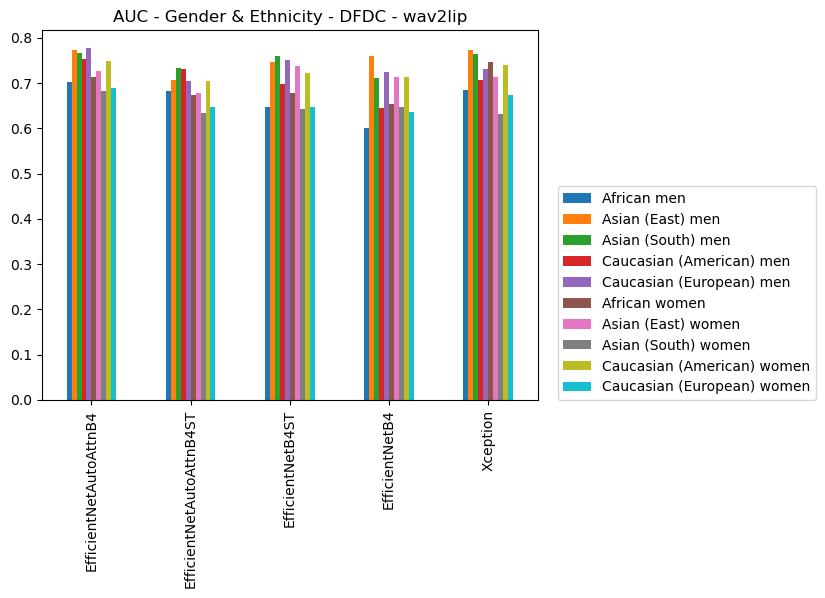

In [145]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - DFDC - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [124]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

                     model             ethnicity gender  accuracy  auc-roc
27  EfficientNetAutoAttnB4         Asian (South)  women      0.62   0.6816
24  EfficientNetAutoAttnB4  Caucasian (European)    men      0.69   0.7776
                       model      ethnicity gender  accuracy  auc-roc
67  EfficientNetAutoAttnB4ST  Asian (South)  women      0.60   0.6348
62  EfficientNetAutoAttnB4ST  Asian (South)    men      0.67   0.7332
               model      ethnicity gender  accuracy  auc-roc
87  EfficientNetB4ST  Asian (South)  women      0.57   0.6424
82  EfficientNetB4ST  Asian (South)    men      0.67   0.7608
            model     ethnicity gender  accuracy   auc-roc
0  EfficientNetB4       African    men  0.540000  0.601600
1  EfficientNetB4  Asian (East)    men  0.646465  0.759592
       model      ethnicity gender  accuracy   auc-roc
47  Xception  Asian (South)  women  0.580000  0.631200
41  Xception   Asian (East)    men  0.676768  0.772245


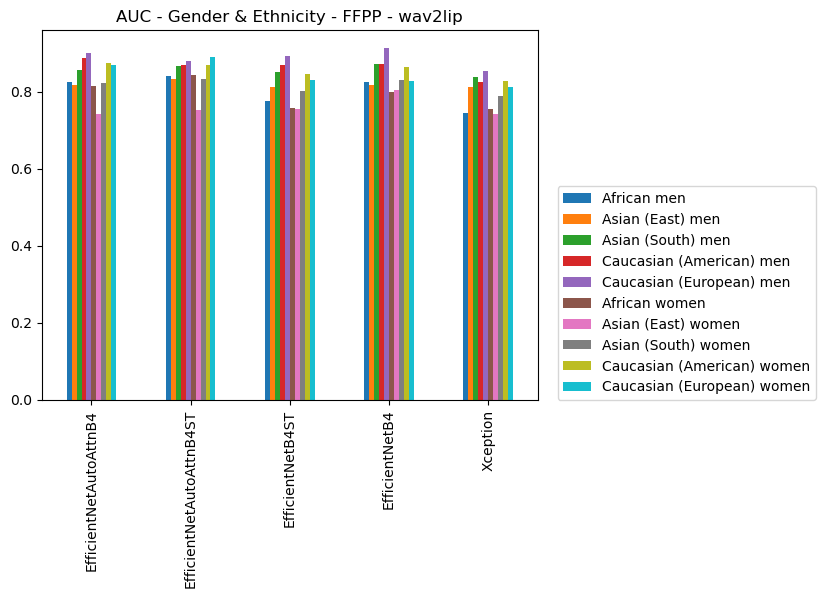

In [146]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - FFPP - wav2lip')
plt.legend(loc=(1.04,0))
plt.show()

In [125]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

                     model             ethnicity gender  accuracy  auc-roc
76  EfficientNetAutoAttnB4          Asian (East)  women      0.67   0.7428
74  EfficientNetAutoAttnB4  Caucasian (European)    men      0.69   0.9008
                       model             ethnicity gender  accuracy  auc-roc
56  EfficientNetAutoAttnB4ST          Asian (East)  women      0.60   0.7540
59  EfficientNetAutoAttnB4ST  Caucasian (European)  women      0.67   0.8904
               model             ethnicity gender  accuracy  auc-roc
36  EfficientNetB4ST          Asian (East)  women      0.68   0.7556
34  EfficientNetB4ST  Caucasian (European)    men      0.79   0.8936
             model             ethnicity gender  accuracy  auc-roc
15  EfficientNetB4               African  women      0.64   0.7992
14  EfficientNetB4  Caucasian (European)    men      0.79   0.9140
       model             ethnicity gender  accuracy  auc-roc
96  Xception          Asian (East)  women      0.63   0.7412
94  Xception  

<ipython-input-170-b32b5941b55e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]


<AxesSubplot:title={'center':'AUC Gender & Ethnicity DFDC_FFPP wav2lip'}, xlabel='subgroup'>

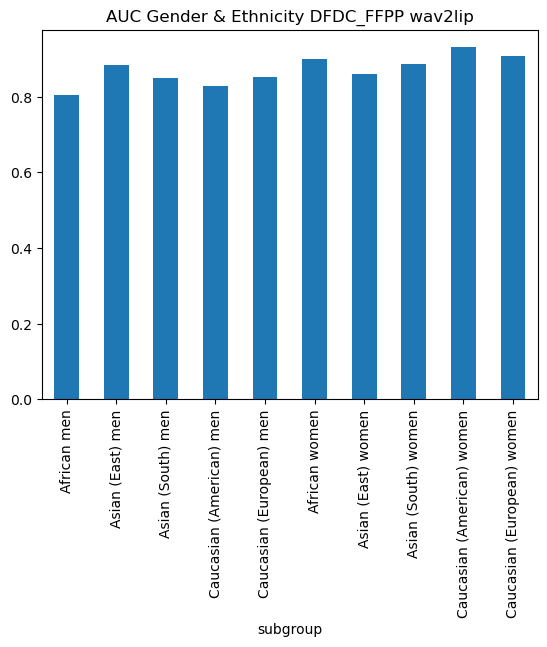

In [170]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]
temp_df.plot.bar(x='subgroup',y='auc-roc',title='AUC Gender & Ethnicity DFDC_FFPP wav2lip',legend=False)

#### Groups with low to high accuracy ( models trained on DFDC )

In [84]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
0,EfficientNetB4,DFDC,men,African,0.540000,0.541667,0.538462,0.52,0.560000,0.530612,0.549020,"[0.0, 0.02, 0.02, 0.12, 0.12, 0.18, 0.18, 0.26...","[0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0.1, 0...","[1.9962889000000001, 0.9962889, 0.99044424, 0....",0.601600
47,Xception,DFDC,women,Asian (South),0.580000,0.558824,0.625000,0.76,0.400000,0.644068,0.487805,"[0.0, 0.02, 0.04, 0.04, 0.14, 0.14, 0.22, 0.22...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.16, ...","[1.9939298600000002, 0.99392986, 0.98858684, 0...",0.631200
67,EfficientNetAutoAttnB4ST,DFDC,women,Asian (South),0.600000,0.564103,0.727273,0.88,0.320000,0.687500,0.444444,"[0.0, 0.02, 0.04, 0.04, 0.2, 0.2, 0.22, 0.22, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9509163, 0.9509163, 0.9123578, 0.9095643, 0...",0.634800
9,EfficientNetB4,DFDC,women,Caucasian (European),0.520000,0.513514,0.538462,0.76,0.280000,0.612903,0.368421,"[0.0, 0.02, 0.04, 0.04, 0.08, 0.08, 0.14, 0.14...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9978382, 0.9978382, 0.99170566, 0.99132043,...",0.635600
87,EfficientNetB4ST,DFDC,women,Asian (South),0.570000,0.547945,0.629630,0.80,0.340000,0.650407,0.441558,"[0.0, 0.02, 0.06, 0.06, 0.16, 0.16, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9778983, 0.9778983, 0.95232046, 0.930991, 0...",0.642400
3,EfficientNetB4,DFDC,men,Caucasian (American),0.580000,0.586957,0.574074,0.54,0.620000,0.562500,0.596154,"[0.0, 0.02, 0.14, 0.14, 0.26, 0.26, 0.34, 0.34...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.12, ...","[1.99291456, 0.99291456, 0.97405237, 0.9729376...",0.644800
69,EfficientNetAutoAttnB4ST,DFDC,women,Caucasian (European),0.600000,0.565789,0.708333,0.86,0.340000,0.682540,0.459459,"[0.0, 0.02, 0.08, 0.08, 0.1, 0.1, 0.2, 0.2, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.9628109, 0.9628109, 0.9232181, 0.91895264, ...",0.646400
80,EfficientNetB4ST,DFDC,men,African,0.580000,0.571429,0.590909,0.64,0.520000,0.603774,0.553191,"[0.0, 0.02, 0.04, 0.04, 0.12, 0.12, 0.2, 0.2, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.08, ...","[1.9688816999999998, 0.9688817, 0.9680903, 0.9...",0.647200
7,EfficientNetB4,DFDC,women,Asian (South),0.600000,0.571429,0.666667,0.80,0.400000,0.666667,0.500000,"[0.0, 0.02, 0.04, 0.04, 0.1, 0.1, 0.12, 0.12, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.99807537, 0.99807537, 0.99736613, 0.9896145...",0.647200
89,EfficientNetB4ST,DFDC,women,Caucasian (European),0.520000,0.512500,0.550000,0.82,0.220000,0.630769,0.314286,"[0.0, 0.02, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9591367, 0.9591367, 0.9459049, 0.94048065, ...",0.647600


#### Groups with low to high accuracy ( models trained on FFPP )

In [85]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
96,Xception,FFPP,women,Asian (East),0.630000,0.589041,0.740741,0.86,0.400000,0.699187,0.519481,"[0.0, 0.02, 0.1, 0.1, 0.16, 0.16, 0.2, 0.2, 0....","[0.0, 0.0, 0.0, 0.06, 0.06, 0.08, 0.08, 0.1, 0...","[1.9356706, 0.9356706, 0.8399179, 0.797869, 0....",0.741200
76,EfficientNetAutoAttnB4,FFPP,women,Asian (East),0.670000,0.619718,0.793103,0.88,0.460000,0.727273,0.582278,"[0.0, 0.02, 0.02, 0.16, 0.16, 0.24, 0.24, 0.34...","[0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0.1, 0...","[1.91152436, 0.91152436, 0.8977813, 0.77035147...",0.742800
90,Xception,FFPP,men,African,0.590000,0.551724,0.846154,0.96,0.220000,0.700730,0.349206,"[0.0, 0.02, 0.06, 0.06, 0.14, 0.14, 0.22, 0.22...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9134902999999999, 0.9134903, 0.8134751, 0.7...",0.745600
56,EfficientNetAutoAttnB4ST,FFPP,women,Asian (East),0.600000,0.562500,0.750000,0.90,0.300000,0.692308,0.428571,"[0.0, 0.02, 0.12, 0.12, 0.16, 0.16, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.86924106, 0.86924106, 0.7604739, 0.70804965...",0.754000
95,Xception,FFPP,women,African,0.630000,0.582278,0.809524,0.92,0.340000,0.713178,0.478873,"[0.0, 0.02, 0.08, 0.08, 0.26, 0.26, 0.3, 0.3, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9612062, 0.9612062, 0.7919503, 0.7873325, 0...",0.755200
36,EfficientNetB4ST,FFPP,women,Asian (East),0.680000,0.632353,0.781250,0.86,0.500000,0.728814,0.609756,"[0.0, 0.02, 0.22, 0.22, 0.3, 0.3, 0.34, 0.34, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9601298, 0.9601298, 0.7184264, 0.716959, 0....",0.755600
35,EfficientNetB4ST,FFPP,women,African,0.660000,0.600000,0.900000,0.96,0.360000,0.738462,0.514286,"[0.0, 0.02, 0.12, 0.12, 0.3, 0.3, 0.38, 0.38, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.91688675, 0.91688675, 0.7926268, 0.7365489,...",0.757600
30,EfficientNetB4ST,FFPP,men,African,0.640000,0.585366,0.888889,0.96,0.320000,0.727273,0.470588,"[0.0, 0.02, 0.16, 0.16, 0.32, 0.32, 0.4, 0.4, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.12, ...","[1.9292970999999999, 0.9292971, 0.6783191, 0.6...",0.776400
97,Xception,FFPP,women,Asian (South),0.740000,0.693548,0.815789,0.86,0.620000,0.767857,0.704545,"[0.0, 0.02, 0.04, 0.04, 0.3, 0.3, 0.46, 0.46, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.12, ...","[1.99123305, 0.99123305, 0.97030354, 0.9486518...",0.788000
15,EfficientNetB4,FFPP,women,African,0.640000,0.589744,0.818182,0.92,0.360000,0.718750,0.500000,"[0.0, 0.02, 0.18, 0.18, 0.2, 0.2, 0.26, 0.26, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.91688675, 0.91688675, 0.6826402, 0.6644632,...",0.799200


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [171]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
100,CrossEffViT,DFDC_FFPP,men,African,0.710000,0.672131,0.769231,0.82,0.600000,0.738739,0.674157,"[0.0, 0.02, 0.04, 0.04, 0.1, 0.1, 0.3, 0.3, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9996527400000002, 0.99965274, 0.99897903, 0...",0.804800
103,CrossEffViT,DFDC_FFPP,men,Caucasian (American),0.650000,0.600000,0.800000,0.90,0.400000,0.720000,0.533333,"[0.0, 0.02, 0.08, 0.08, 0.1, 0.1, 0.24, 0.24, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99857473, 0.99857473, 0.980011, 0.9606824, ...",0.827200
102,CrossEffViT,DFDC_FFPP,men,Asian (South),0.680000,0.625000,0.821429,0.90,0.460000,0.737705,0.589744,"[0.0, 0.02, 0.2, 0.2, 0.3, 0.3, 0.32, 0.32, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9767931, 0.9767931, 0.8099896, 0.8073393, 0...",0.848800
104,CrossEffViT,DFDC_FFPP,men,Caucasian (European),0.670000,0.616438,0.814815,0.90,0.440000,0.731707,0.571429,"[0.0, 0.02, 0.08, 0.08, 0.22, 0.22, 0.28, 0.28...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.08, ...","[1.9780896000000001, 0.9780896, 0.91391313, 0....",0.851600
106,CrossEffViT,DFDC_FFPP,women,Asian (East),0.720000,0.677419,0.789474,0.84,0.600000,0.750000,0.681818,"[0.0, 0.02, 0.06, 0.06, 0.32, 0.32, 0.36, 0.36...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9962949, 0.9962949, 0.97379136, 0.9695839, ...",0.858800
101,CrossEffViT,DFDC_FFPP,men,Asian (East),0.787879,0.737705,0.868421,0.90,0.673469,0.810811,0.758621,"[0.0, 0.02040816326530612, 0.02040816326530612...","[0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, 0.06,...","[1.9999331, 0.9999331, 0.99694365, 0.7902216, ...",0.882041
107,CrossEffViT,DFDC_FFPP,women,Asian (South),0.790000,0.730159,0.891892,0.92,0.660000,0.814159,0.758621,"[0.0, 0.02, 0.1, 0.1, 0.5, 0.5, 0.6, 0.6, 0.68...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9960909500000001, 0.99609095, 0.9546162, 0....",0.886000
105,CrossEffViT,DFDC_FFPP,women,African,0.740000,0.676471,0.875000,0.92,0.560000,0.779661,0.682927,"[0.0, 0.02, 0.42, 0.42, 0.48, 0.48, 0.54, 0.54...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.08, ...","[1.99945086, 0.99945086, 0.63738257, 0.6184567...",0.898000
109,CrossEffViT,DFDC_FFPP,women,Caucasian (European),0.720000,0.652778,0.892857,0.94,0.500000,0.770492,0.641026,"[0.0, 0.02, 0.06, 0.06, 0.34, 0.34, 0.4, 0.4, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9979697, 0.9979697, 0.9773258, 0.91019475, ...",0.907200
108,CrossEffViT,DFDC_FFPP,women,Caucasian (American),0.810000,0.731343,0.969697,0.98,0.640000,0.837607,0.771084,"[0.0, 0.02, 0.64, 0.64, 0.68, 0.68, 0.7, 0.7, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9753381, 0.9753381, 0.5203762, 0.5137826, 0...",0.929600
